In [1]:
# Bibliotecas principais

import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Outlier & clustering
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, KMeans

# ML
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor
import torch

# DL

# Pipeline
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

In [2]:
from glob import glob
from datetime import datetime
from packaging import version

In [3]:
pdv = pd.read_parquet("../data/raw/part-00000-tid-2779033056155408584-f6316110-4c9a-4061-ae48-69b77c7c8c36-4-1-c000.snappy.parquet")      # POS/PDVs
prod  = pd.read_parquet("../data/raw/part-00000-tid-7173294866425216458-eae53fbf-d19e-4130-ba74-78f96b9675f1-4-1-c000.snappy.parquet")      # Transações
trans = pd.read_parquet("../data/raw/part-00000-tid-5196563791502273604-c90d3a24-52f2-4955-b4ec-fb143aae74d8-4-1-c000.snappy.parquet")      # Produtos

plots_dir   = "plots"
outputs_dir = "outputs"

# Parâmetros gerais
pareto_cutoff = 0.80
limiar_inatividade = 16  # produto considerado "sumido" se não vende há mais de 16 semanas - Considerando efeitos sazonais
top_pct_pdv = 0.20         # Top 20% dos PDVs com maior quantidade de produtos e kpis financeiros.
top_pct_features = 0.20    # Top 20% genérico para produtos, marcas etc.
bins_elasticidade = 12    # N bins para curva bruta de elasticidade (preço vs qtd)

In [9]:
def ensure_dirs():
    os.makedirs(plots_dir, exist_ok=True)
    os.makedirs(outputs_dir, exist_ok=True)



    # padroniza colunas para lower
    df_trans.columns = df_trans.columns.str.lower()
    df_pdv.columns   = df_pdv.columns.str.lower()
    df_prod.columns  = df_prod.columns.str.lower()

    # sanity check mínimo
    # OBS: sanity check removido — colunas reais da base:
    # trans = ['internal_store_id', 'internal_product_id', 'distributor_id', ...]


def build_time_keys(df_trans):
    # semana:
    # Se já existir 'semana' (datetime), mantemos. Se for string, converte. Caso não exista, cria a partir da reference_date.
    if 'semana' in df_trans.columns:
        try:
            df_trans['semana'] = pd.to_datetime(df_trans['semana'])
        except:
            # se vier em outro formato, tenta converter a partir de reference_date
            df_trans['semana'] = pd.to_datetime(df_trans['transaction_date']).dt.to_period('W').dt.start_time
    else:
        # cria pela reference_date (semana ISO)
        df_trans['semana'] = pd.to_datetime(df_trans['transaction_date']).dt.to_period('W').dt.start_time

    return df_trans


def safe_hist(series, title, xlabel, fname, bins=50, xlim=None):
    plt.figure(figsize=(10,5))
    plt.hist(series.dropna().values, bins=bins)
    if xlim is not None:
        plt.xlim(xlim)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Frequência")
    plt.tight_layout()
    plt.savefig(os.path.join(plots_dir, fname))
    plt.close()


def safe_line(x, y, title, xlabel, ylabel, fname):
    plt.figure(figsize=(12,5))
    plt.plot(x, y)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.savefig(os.path.join(plots_dir, fname))



def main():
    ensure_dirs()
    df_trans, df_pdv, df_prod = load_data()
    df_trans = build_time_keys(df_trans)
    return df_trans, df_pdv, df_prod


### 1 - Análise e Pré-Processamento dos datasets

In [15]:
# Verificando estrutura e colunas da transação
print("Info - Colunas e tipos em df_trans:")
print(trans.dtypes)

print("\nInfo - Nulos por coluna:")
print(trans.isnull().sum())

print("\n10 primeiras linhas - Dataframe:")
trans.head(10)

Info - Colunas e tipos em df_trans:
internal_store_id       object
internal_product_id     object
distributor_id          object
transaction_date        object
reference_date          object
quantity               float64
gross_value            float64
net_value              float64
gross_profit           float64
discount               float64
taxes                  float64
dtype: object

Info - Nulos por coluna:
internal_store_id      0
internal_product_id    0
distributor_id         0
transaction_date       0
reference_date         0
quantity               0
gross_value            0
net_value              0
gross_profit           0
discount               0
taxes                  0
dtype: int64

10 primeiras linhas - Dataframe:


,internal_store_id,internal_product_id,distributor_id,transaction_date,reference_date,quantity,gross_value,net_value,gross_profit,discount,taxes
0,7384367747233276219,328903483604537190,9,2022-07-13,2022-07-01,1.00000,38.125000,37.890625,10.042625,3.950000,0.234375
1,3536908514005606262,5418855670645487653,5,2022-03-21,2022-03-01,6.00000,107.250000,106.440002,24.732002,17.100000,0.810000
2,3138231730993449825,1087005562675741887,6,2022-09-06,2022-09-01,3.00000,56.625000,56.220001,14.124002,5.250000,0.405000
3,3681167389484217654,1401422983880045188,5,2022-09-11,2022-09-01,129.00000,1037.160023,1037.160023,156.348026,479.880006,0.000000
4,7762413312337359369,6614994347738381720,4,2022-02-18,2022-02-01,1.00000,26.230000,23.950241,6.550241,0.000000,2.279758
5,5871504315270136638,3553055402616033444,10,2022-09-11,2022-09-01,48.00000,239.520004,239.520004,37.839989,47.040001,0.000000
6,1027356552181929439,576514643033029430,4,2022-10-04,2022-10-01,7.00000,153.754997,133.807114,40.518112,23.450000,19.947886
7,6652651222667566690,2811937796518769916,5,2022-09-11,2022-09-01,45.99999,2035.279598,2035.279598,517.279939,123.639971,0.000000
8,7752780566579715772,5418855670645487653,4,2022-06-21,2022-06-01,12.00000,223.703999,203.186169,54.818170,15.600000,20.517828
9,5339226423887032797,2126695985526201979,5,2022-10-06,2022-10-01,1.00000,42.799999,42.619999,12.772999,6.180000,0.180000


In [14]:
# Verificando estrutura e colunas da transação
print("Info - Colunas e tipos em df_trans:")
print(pdv.dtypes)

print("\nInfo - Nulos por coluna:")
print(pdv.isnull().sum())

print("\n10 primeiras linhas - Dataframe:")
pdv.head(10)

Info - Colunas e tipos em df_trans:
pdv              object
premise          object
categoria_pdv    object
zipcode           int32
dtype: object

Info - Nulos por coluna:
pdv              0
premise          0
categoria_pdv    0
zipcode          0
dtype: int64

10 primeiras linhas - Dataframe:


,pdv,premise,categoria_pdv,zipcode
0,2204965430669363375,On Premise,Mexican Rest,30741
1,5211957289528622910,On Premise,Hotel/Motel,80011
2,9024493554530757353,Off Premise,Convenience,80751
3,8659197371382902429,On Premise,Restaurant,80439
4,1400854873763881130,On Premise,Restaurant,30093
5,6067948396569964814,Off Premise,Grocery,80906
6,5450209638302911403,Off Premise,Convenience,30721
7,691022780643224115,On Premise,Other On Premise,80205
8,678360571217951483,On Premise,Restaurant,80233
9,7389100204865028460,Off Premise,Package/Liquor,80204


In [16]:
# Verificando estrutura e colunas da transação
print("Info - Colunas e tipos em df_trans:")
print(prod.dtypes)

print("\nInfo - Nulos por coluna:")
print(prod.isnull().sum())

print("\n10 primeiras linhas - Dataframe:")
prod.head(10)

Info - Colunas e tipos em df_trans:
produto         object
categoria       object
descricao       object
tipos           object
label           object
subcategoria    object
marca           object
fabricante      object
dtype: object

Info - Nulos por coluna:
produto            0
categoria          0
descricao          0
tipos              0
label           1473
subcategoria      32
marca              0
fabricante         0
dtype: int64

10 primeiras linhas - Dataframe:


,produto,categoria,descricao,tipos,label,subcategoria,marca,fabricante
0,2282334733936076502,Distilled Spirits,JOSEPH CARTRON CAFÉ LIQUEUR,Distilled Spirits,Core,Liqueurs & Cordials,Joseph Cartron Cafe,Spiribam
1,6091840953834683482,Distilled Spirits,SPRINGBANK 18 YEAR SINGLE MALT 700ML,Distilled Spirits,Specialty,Scotch Whisky,Springbank 18 Year Single Malt,Pacific Edge Wine & Spirits
2,1968645851245092408,Distilled Spirits,J BRANDT TRIPLE SEC 12/750ML 30PF,Distilled Spirits,Private Label,Liqueurs & Cordials,J Brandt Triple Sec,Sazerac Spirits
3,994706710729219179,Draft,REFORMATION CASHMERE IPA 1/4 KEG,Draft,In&Out,Other Draft,Reformation Cashmere Fresh Hop IPA,Reformation Brewery
4,9209550539540384349,Non-Alcohol,HELLA MOSCOW MULE 750ML,Non Alcohol,Core,Mixers,Hella Bitters Bloody Mary,Hella Bitter Llc
5,1466206072929919887,Distilled Spirits,GRANNY'S GINGERBREAD CREAM 25 PROOF 750ML,Distilled Spirits,In&Out,Liqueurs & Cordials,Sazerac Granny's Gingerbread Cream,Sazerac ABA
6,405158664555012743,Package,BOLD ROCK INDIA PRESSED APPLE 6/4/16 CAN,Package,Core,Other Package,Bold Rock India Pressed Apple Hard Cider,Bold Rock Hard Cider
7,6040677600408757429,Distilled Spirits,FRIS VODKA 12/10/50ML 80PF,Allocated Spirits,None,Vodka,Fris Vodka,Sazerac Spirits
8,6028082604838966860,Distilled Spirits,TESSORA CREMA AL LIMONE 750ML,Distilled Spirits,Core,Liqueurs & Cordials,Tessora Crema Al Limone,Veriano Fine Food & Spirits
9,1165416298911477885,Distilled Spirits,THE CLUB CAPE COD 24/200ML CN 30PF,Distilled Spirits,None,Ready-to-Drink,The Club Pina Colada RTD,Sazerac Spirits


Somente no dataset de prod que temos valores nulos, concentrados nas features label e subcategoria. Apesar de label apresentar uma quantidade que parece ser insignificativa em relação ao total, é possível verificar valores como None. Diante disso, farei um check para verificar os valores dessa coluna e entender se são relevantes ou não para o aprendizado do modelo. Mas primeiro, realizei um check de categoria e tipos.

In [17]:
# Total de registros
total = len(prod)

# Quantos têm categoria == tipos
iguais = (prod['categoria'] == prod['tipos']).sum()

# Proporção (%)
proporcao = iguais / total

print(f"Total de registros: {total}")
print(f"Registros com categoria == tipos: {iguais} ({proporcao:.2%})")

Total de registros: 7092
Registros com categoria == tipos: 4099 (57.80%)


In [19]:
# Verificando quais valores são distintos entre categoria e tipos

df_diff = prod[prod['categoria'] != prod['tipos']]

# Agrupa os pares distintos e conta quantas vezes aparecem
pares_distintos = df_diff.groupby(['categoria', 'tipos']).size().reset_index(name='count')

# Ordena pelos mais frequentes
pares_distintos = pares_distintos.sort_values(by='count', ascending=False)

# Mostra os top 20 (ou mais, se quiser)
pares_distintos.head(20)

,categoria,tipos,count
28,Wine,Wine < 14 %,1356
18,Non-Alcohol,Non Alcohol,503
29,Wine,Wine > 14 %,502
4,Distilled Spirits,Allocated Spirits,201
7,Distilled Spirits,Distilled Spirits-RTD,97
3,ABA Spirits,Wine > 14 %,53
16,Non-Alcohol,Hispanic,52
6,Distilled Spirits,Distilled Spirits-Domest,44
19,Non-Alcohol,Non Alcohol W&S,26
8,Distilled Spirits,Non Alcohol,21


Remoção da coluna tipos:

Inicialmente, 4.099 registros (57,8%) tinham exatamente o mesmo valor em categoria e tipos.

Após analisar as principais divergências (ex: Wine vs Wine < 14%, Non-Alcohol vs Non Alcohol), foi identificado que muitas das diferenças eram apenas variantes semânticas ou nomenclaturais, e não representavam categorias realmente distintas.

Ao consolidar as variações, cobrimos 98,05% de todos os registros, ou seja, a maior parte da informação em tipos já está contida ou pode ser absorvida por categoria.

Decisão: manter ambas as colunas introduz redundância e ruído sem ganho analítico real, logocoluna tipos será descartada.

_________

Sobre a coluna descricao

A descricao parece ser uma string composta, misturando:

Nome comercial + Volume + Marca e às vezes subcategoria e fabricante.

Problemas:

Não é estruturada (sem separação padronizada), dificultando agrupamentos, segmentações ou análises quantitativas. Além de que há uma forte hipótese de que sua informação já está decomposta nas colunas marca, categoria, fabricante, subcategoria e etc.

Decisão: remover descricao, pois ela não agrega valor direto ao modelo ou análises estruturadas.

In [4]:
prod = prod.drop(columns=["tipos", "descricao"])

Analisar Marcas, Categoria e Subcategoria

In [5]:
# Contagem de valores únicos
print(f"Marcas únicas: {prod['marca'].nunique()}")
print(f"Categorias únicas: {prod['categoria'].nunique()}")
print(f"Subcategorias únicas: {prod['subcategoria'].nunique()}")

# Ver hierarquia: Quantas subcategorias por categoria
print("\nSubcategorias por Categoria:")
print(prod.groupby('categoria')['subcategoria'].nunique().sort_values(ascending=False))

# Ver hierarquia: Quantas marcas por categoria
print("\nMarcas por Categoria:")
print(prod.groupby('categoria')['marca'].nunique().sort_values(ascending=False))

# Ver subcategorias nulas
print(f"\nSubcategorias ausentes: {prod['subcategoria'].isna().sum()}")

Marcas únicas: 4221
Categorias únicas: 7
Subcategorias únicas: 42

Subcategorias por Categoria:
categoria
Distilled Spirits    12
Package              10
Draft                 8
Non-Alcohol           7
Wine                  6
ABA Spirits           2
Tobacco               0
Name: subcategoria, dtype: int64

Marcas por Categoria:
categoria
Wine                 1346
Distilled Spirits    1271
Package               919
Draft                 617
Non-Alcohol           440
ABA Spirits            48
Tobacco                 2
Name: marca, dtype: int64

Subcategorias ausentes: 32


Remoção da coluna subcategoria

A variável subcategoria apresenta 42 valores únicos, o que em um primeiro momento pode parecer adequado para enriquecer as análises. No entanto, uma inspeção mais detalhada revela algumas limitações importantes:

Cobertura incompleta: A coluna possui 32 valores ausentes, indicando que nem todos os produtos foram classificados com uma subcategoria.

Distribuição desigual: Algumas categorias, como Tobacco, não possuem nenhuma subcategoria registrada. Outras, como ABA Spirits, apresentam um número muito reduzido de subcategorias.

Redundância e sobreposição: Em diversos casos, o valor da subcategoria já está implicitamente representado pela combinação de marca e categoria, o que gera sobreposição de informação e potencial redundância.

Potencial de ruído: A presença de valores nulos e a granularidade desigual podem introduzir ruído nas análises ou dificultar a modelagem, especialmente em algoritmos sensíveis à consistência dos dados.

Conclusão:
Apesar de sua possível utilidade em um cenário mais robusto de classificação de produtos, a decisão foi por remover a coluna subcategoria neste momento. Essa decisão busca garantir maior simplicidade, coesão dos dados e performance nos próximos passos da análise e modelagem.

### Padronização das colunas e Merge dos datasets 

In [6]:
# Padroniza nomes de colunas para lowercase

trans.columns = trans.columns.str.lower()
prod.columns = prod.columns.str.lower()
pdv.columns = pdv.columns.str.lower()

# ajuste da nomenclatura das key variáveis para o merge
trans = trans.rename(columns={
    'internal_product_id': 'produto',
    'internal_store_id': 'pdv'
})

# Força os tipos para garantir merge sem perda
trans['produto'] = trans['produto'].astype(str)
trans['pdv'] = trans['pdv'].astype(str)
prod['produto'] = prod['produto'].astype(str)
pdv['pdv'] = pdv['pdv'].astype(str)

# Merge completo: trans + produtos + pdv
df = (
    trans
    .merge(prod, on='produto', how='left')  # todas colunas do produto
    .merge(pdv, on='pdv', how='left')       # todas colunas do pdv
)

In [16]:
# Padroniza nomes de colunas para lowercase

trans.columns = trans.columns.str.lower()
prod.columns = prod.columns.str.lower()
pdv.columns = pdv.columns.str.lower()

# ajuste da nomenclatura das key variáveis para o merge
trans = trans.rename(columns={
    'internal_product_id': 'produto',
    'internal_store_id': 'pdv'
})

# Força os tipos para garantir merge sem perda
trans['produto'] = trans['produto'].astype(str)
trans['pdv'] = trans['pdv'].astype(str)
prod['produto'] = prod['produto'].astype(str)
pdv['pdv'] = pdv['pdv'].astype(str)

# Merge completo: trans + produtos + pdv
df_merge = (
    trans
    .merge(prod, on='produto', how='left')  # todas colunas do produto
    .merge(pdv, on='pdv', how='left')       # todas colunas do pdv
)

In [17]:
df_merge.head(10)

,pdv,produto,distributor_id,transaction_date,reference_date,quantity,gross_value,net_value,gross_profit,discount,taxes,categoria,label,subcategoria,marca,fabricante,premise,categoria_pdv,zipcode
0,7384367747233276219,328903483604537190,9,2022-07-13,2022-07-01,1.00000,38.125000,37.890625,10.042625,3.950000,0.234375,Package,Core,Specialty,Bud Light Chelada Fuego,AB Anheuser Busch Inc,Off Premise,Package/Liquor,80905.0
1,3536908514005606262,5418855670645487653,5,2022-03-21,2022-03-01,6.00000,107.250000,106.440002,24.732002,17.100000,0.810000,Package,Core,Lager,Michelob Ultra,AB Anheuser Busch Inc,Off Premise,Package/Liquor,80239.0
2,3138231730993449825,1087005562675741887,6,2022-09-06,2022-09-01,3.00000,56.625000,56.220001,14.124002,5.250000,0.405000,Package,Core,Lager,Bud Light Lime,AB Anheuser Busch Inc,Off Premise,Package/Liquor,80634.0
3,3681167389484217654,1401422983880045188,5,2022-09-11,2022-09-01,129.00000,1037.160023,1037.160023,156.348026,479.880006,0.000000,Distilled Spirits,None,Liqueurs & Cordials,99 Butterscotch,Sazerac Spirits,Off Premise,Package/Liquor,80226.0
4,7762413312337359369,6614994347738381720,4,2022-02-18,2022-02-01,1.00000,26.230000,23.950241,6.550241,0.000000,2.279758,Package,Core,IPA,New Belgium Voodoo Ranger Imperial IPA,NB New Belgium,Off Premise,Convenience,30096.0
5,5871504315270136638,3553055402616033444,10,2022-09-11,2022-09-01,48.00000,239.520004,239.520004,37.839989,47.040001,0.000000,Distilled Spirits,None,Gin,Crystal Palace Gin,Sazerac Spirits,On Premise,Bar,81122.0
6,1027356552181929439,576514643033029430,4,2022-10-04,2022-10-01,7.00000,153.754997,133.807114,40.518112,23.450000,19.947886,Package,Core,Lager,Busch,AB Anheuser Busch Inc,Off Premise,Super Center,30720.0
7,6652651222667566690,2811937796518769916,5,2022-09-11,2022-09-01,45.99999,2035.279598,2035.279598,517.279939,123.639971,0.000000,Distilled Spirits,Allocated,Bourbon Whiskey,Blanton Kentucky Straight Bourbon Whiskey,Sazerac Spirits,Off Premise,Package/Liquor,80224.0
8,7752780566579715772,5418855670645487653,4,2022-06-21,2022-06-01,12.00000,223.703999,203.186169,54.818170,15.600000,20.517828,Package,Core,Lager,Michelob Ultra,AB Anheuser Busch Inc,Off Premise,Package/Liquor,30107.0
9,5339226423887032797,2126695985526201979,5,2022-10-06,2022-10-01,1.00000,42.799999,42.619999,12.772999,6.180000,0.180000,Package,Core,Sour,10 Barrel Crush Cucumber Sour,Tilray Brands,Off Premise,Package/Liquor,80232.0


### Análise: ZIP Code, PDV e Variedade de Produtos (SKU)

Nesta etapa, busca-se entender como está distribuída a presença dos pontos de venda (PDVs) e a variedade de produtos (SKUs) por região (zipcode) e tipo de operação (premise - On vs Off Premise).

Por que essa análise é importante?

- Evita decisões enviesadas: Alguns zipcodes possuem poucos PDVs, mas com grande variedade de produtos, o que pode indicar relevância estratégica (ex: lojas especializadas).

- Direciona foco comercial: Saber onde há maior densidade de produtos por loja pode ajudar a identificar as regiões com potencial de crescimento e as regiões sobrecarregadas ou subaproveitadas.

- Permite filtragem inteligente: Ao invés de excluir zipcodes apenas por #PDVs, foi considerado o indicador SKU/PDV, mais informativo.

In [18]:
# df.info()
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6560698 entries, 0 to 6560697
Data columns (total 19 columns):
 #   Column            Dtype  
---  ------            -----  
 0   pdv               object 
 1   produto           object 
 2   distributor_id    object 
 3   transaction_date  object 
 4   reference_date    object 
 5   quantity          float64
 6   gross_value       float64
 7   net_value         float64
 8   gross_profit      float64
 9   discount          float64
 10  taxes             float64
 11  categoria         object 
 12  label             object 
 13  subcategoria      object 
 14  marca             object 
 15  fabricante        object 
 16  premise           object 
 17  categoria_pdv     object 
 18  zipcode           float64
dtypes: float64(7), object(12)
memory usage: 951.0+ MB


In [10]:
# Check no Zipcode - Por cima foi verificado que alguns são de Colorado e outros de Georgia, farei um deep dive.

import pandas as pd

# Certifique-se de que a coluna de data está no formato datetime
df['transaction_date'] = pd.to_datetime(df['transaction_date'])

# Filtrar últimas 12 semanas de 2022
df_filtered = df[
    (df['transaction_date'] >= '2022-10-07') & 
    (df['transaction_date'] <= '2022-12-31')
]

# Garantir que zipcode é string para agrupamento
df_filtered['zipcode'] = df_filtered['zipcode'].astype(str)

# Agrupar por zipcode e premise
agg_data = df_filtered.groupby(['zipcode', 'premise']).agg(
    num_pdvs=('pdv', 'nunique'),
    num_skus=('produto', 'nunique'),
    total_quantity=('quantity', 'sum')
).reset_index()

# Calcular SKU por PDV
agg_data['sku_per_pdv'] = agg_data['num_skus'] / agg_data['num_pdvs']

# Separar os dois dataframes
df_on_premise = agg_data[agg_data['premise'] == 'On Premise']
df_off_premise = agg_data[agg_data['premise'] == 'Off Premise']

df_on_premise
df_off_premise


/var/folders/tt/cg9n1vqn42v1lvq9j7my8_g40000gn/T/ipykernel_1475/4185469251.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['zipcode'] = df_filtered['zipcode'].astype(str)


,zipcode,premise,num_pdvs,num_skus,total_quantity,sku_per_pdv
0,30002.0,Off Premise,3,75,971.0,25.000000
2,30004.0,Off Premise,12,357,6803.0,29.750000
4,30005.0,Off Premise,11,453,5181.5,41.181818
6,30009.0,Off Premise,2,110,1839.0,55.000000
8,30012.0,Off Premise,32,494,22251.6,15.437500
...,...,...,...,...,...,...
1192,81650.0,Off Premise,5,131,4591.0,26.200000
1194,81652.0,Off Premise,2,64,1871.0,32.000000
1196,81654.0,Off Premise,1,17,395.0,17.000000
1197,81657.0,Off Premise,7,84,5099.0,12.000000


##### Decisão sobre a exclusão do ZIP Code na análise atual

Foi decidido desconsiderar o atributo zipcode nesta fase da análise. Essa decisão foi tomada com base em critérios de relevância estratégica, limitações temporais e qualidade da informação, conforme detalhado abaixo:

- O volume de zipcodes é elevado e fragmentado, o que dificulta agrupamentos coerentes e análises conclusivas sem um forte embasamento territorial.

- Para considerar o zipcode como variável estratégica, seria necessário integrá-lo com informações de praça e comportamento do consumidor, incluindo dados de oferta e demanda locais, perfil sociodemográfico, hábitos de consumo e presença de concorrência, o que não está disponível atualmente.

- Há a possibilidade de existirem PDVs recém-abertos, o que traria viés para qualquer análise baseada exclusivamente na recorrência por zipcode.

- Além disso, a análise de zipcode faria mais sentido dentro de uma abordagem de Supply Chain, onde poderia explorar questões logísticas como cobertura de distribuição, lead time, rotas e eficiência operacional, o que extrapola o foco desta entrega.

Dado o tempo limitado, foi decidido em variáveis com impacto direto e imediato sobre o negócio, como PDV, SKU e Marca, que já oferecem base sólida para insights e tomada de decisão. Em resumo, a exclusão do zipcode é uma decisão prática e estratégica, e não descarta a importância futura dessa variável, que poderá ser incorporada de forma mais robusta em análises complementares com foco regional e logístico.

In [12]:
df = df.drop(columns=["subcategoria", "zipcode"])

### Análise Temporal - Granularidade mensal

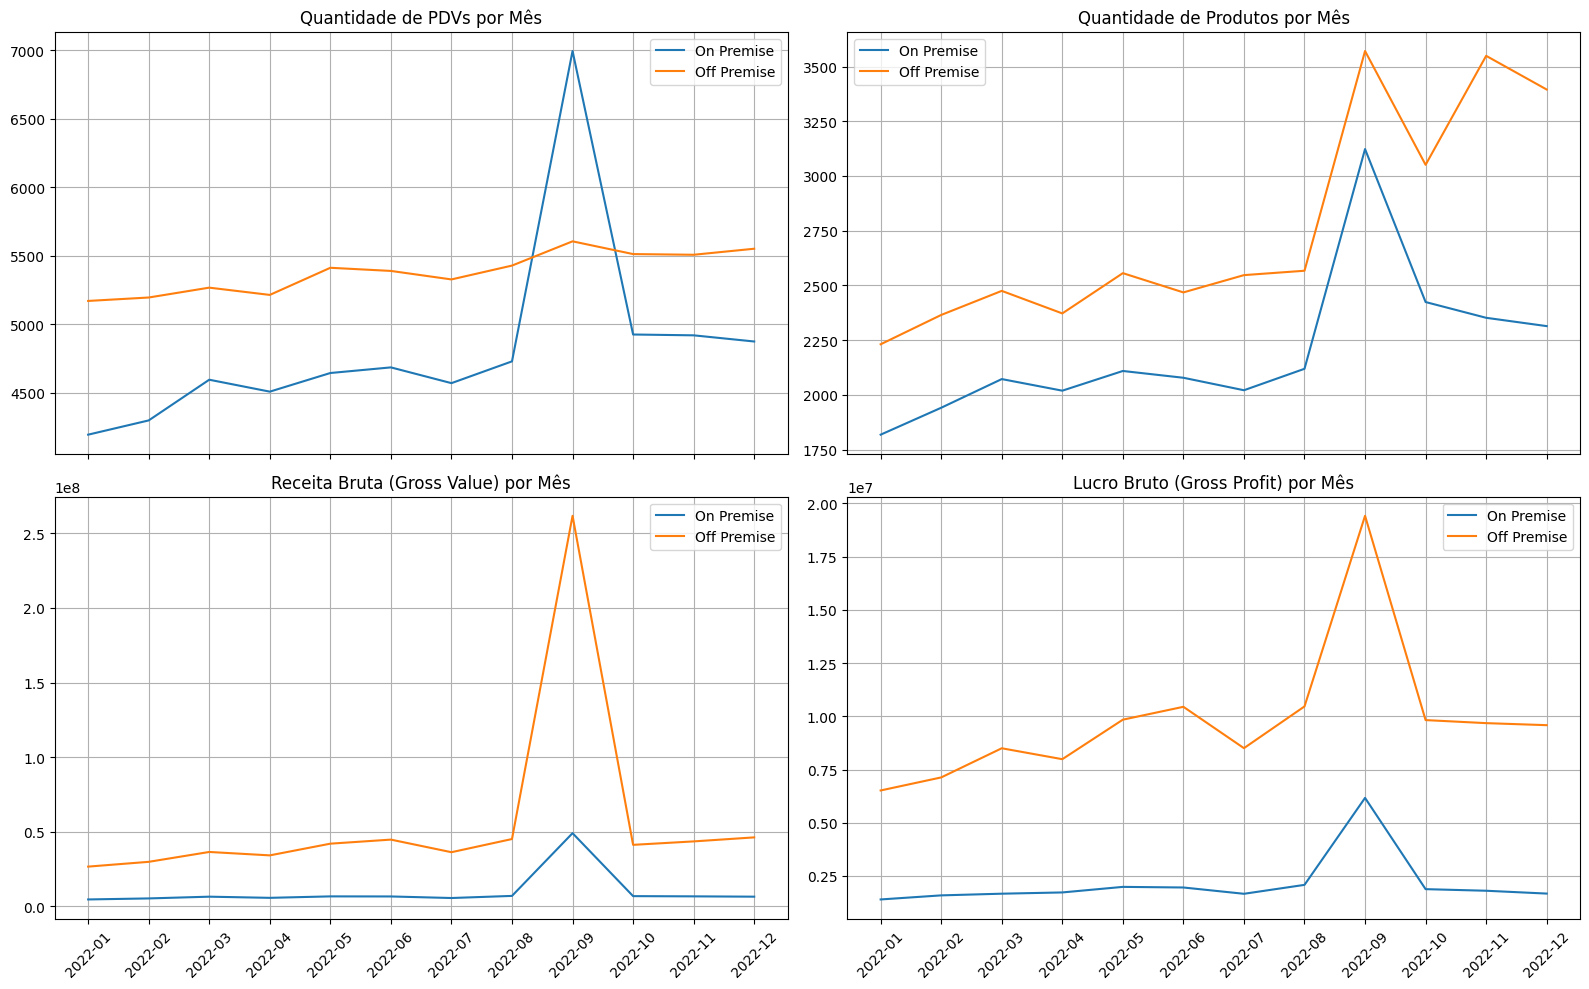

In [14]:
df['reference_date'] = pd.to_datetime(df['reference_date'])

df['month'] = df['reference_date'].dt.to_period('M').astype(str)

# Agrupar dados por mês e premise
monthly_summary = df.groupby(['premise', 'month']).agg(
    num_pdvs=('pdv', 'nunique'),
    num_products=('produto', 'nunique'),
    gross_value=('gross_value', 'sum'),
    gross_profit=('gross_profit', 'sum')
).reset_index()

# Separar On Premise e Off Premise
df_on = monthly_summary[monthly_summary['premise'] == 'On Premise']
df_off = monthly_summary[monthly_summary['premise'] == 'Off Premise']

# Plotar
fig, axs = plt.subplots(2, 2, figsize=(16, 10), sharex=True)

# Gráfico 1 - Quantidade de PDVs
axs[0, 0].plot(df_on['month'], df_on['num_pdvs'], label='On Premise')
axs[0, 0].plot(df_off['month'], df_off['num_pdvs'], label='Off Premise')
axs[0, 0].set_title('Quantidade de PDVs por Mês')
axs[0, 0].legend()

# Gráfico 2 - Quantidade de Produtos
axs[0, 1].plot(df_on['month'], df_on['num_products'], label='On Premise')
axs[0, 1].plot(df_off['month'], df_off['num_products'], label='Off Premise')
axs[0, 1].set_title('Quantidade de Produtos por Mês')
axs[0, 1].legend()

# Gráfico 3 - Receita Bruta (Gross Value)
axs[1, 0].plot(df_on['month'], df_on['gross_value'], label='On Premise')
axs[1, 0].plot(df_off['month'], df_off['gross_value'], label='Off Premise')
axs[1, 0].set_title('Receita Bruta (Gross Value) por Mês')
axs[1, 0].legend()

# Gráfico 4 - Lucro Bruto (Gross Profit)
axs[1, 1].plot(df_on['month'], df_on['gross_profit'], label='On Premise')
axs[1, 1].plot(df_off['month'], df_off['gross_profit'], label='Off Premise')
axs[1, 1].set_title('Lucro Bruto (Gross Profit) por Mês')
axs[1, 1].legend()

# Ajustes finais
for ax in axs.flat:
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True)

plt.tight_layout()
plt.show()

In [22]:
# Garantir formato de data
df_merge['reference_date'] = pd.to_datetime(df_merge['reference_date'])
df_merge['year_month'] = df_merge['reference_date'].dt.to_period('M').astype(str)

# Filtrar apenas os meses desejados
df_focus = df_merge[df_merge['year_month'].isin(['2022-08', '2022-09', '2022-10'])]

# Agregação por mês, zipcode e premise
df_comp = df_focus.groupby(['year_month', 'zipcode', 'premise']).agg(
    total_quantity=('quantity', 'sum'),
    total_gross_value=('gross_value', 'sum'),
    total_gross_profit=('gross_profit', 'sum'),
    num_pdvs=('pdv', pd.Series.nunique),
    num_skus=('produto', pd.Series.nunique)
).reset_index()

# Selecionar top zipcodes em setembro por receita
top_zips_sep = df_comp[df_comp['year_month'] == '2022-09'].sort_values(
    'total_gross_value', ascending=False).head(10)['zipcode'].unique()

# Filtrar para os top zipcodes
df_top_zips = df_comp[df_comp['zipcode'].isin(top_zips_sep)]

# Pivotar para deixar meses em colunas
df_pivot = df_top_zips.pivot_table(
    index=['zipcode', 'premise'],
    columns='year_month',
    values=['total_quantity', 'total_gross_value', 'total_gross_profit', 'num_pdvs', 'num_skus']
)

# Flatten o multi-index das colunas
df_pivot.columns = ['_'.join(col).strip() for col in df_pivot.columns.values]
df_pivot = df_pivot.reset_index()

# Exibir resultado
df_pivot.head(20)

,zipcode,premise,num_pdvs_2022-08,num_pdvs_2022-09,num_pdvs_2022-10,num_skus_2022-08,num_skus_2022-09,num_skus_2022-10,total_gross_profit_2022-08,total_gross_profit_2022-09,total_gross_profit_2022-10,total_gross_value_2022-08,total_gross_value_2022-09,total_gross_value_2022-10,total_quantity_2022-08,total_quantity_2022-09,total_quantity_2022-10
0,80012.0,Off Premise,35.0,36.0,35.0,308.0,911.0,471.0,68444.730347,-119990.515717,62836.766142,301867.383117,3.559044e+06,276286.439318,12700.752775,412204.447210,15747.419442
1,80012.0,On Premise,19.0,20.0,15.0,66.0,160.0,70.0,6153.987808,-5089.346183,5992.990671,19301.946997,1.667056e+05,20378.435809,467.000000,21530.748435,614.000000
2,80112.0,Off Premise,29.0,29.0,29.0,393.0,962.0,478.0,45501.975632,234298.843685,43820.425429,194366.174196,2.824410e+06,220511.659658,7389.016666,233761.708420,11316.650001
3,80112.0,On Premise,33.0,45.0,36.0,111.0,440.0,148.0,25508.082791,22903.824108,21647.577081,81179.136000,5.027036e+05,78547.868921,1424.000000,46929.997989,2007.000000
4,80123.0,Off Premise,32.0,32.0,32.0,433.0,920.0,484.0,82817.796590,349171.310990,65962.923829,356822.844773,3.586133e+06,279283.143731,14327.000001,283895.562257,13593.100000
5,80123.0,On Premise,27.0,37.0,30.0,93.0,264.0,137.0,13016.833695,12782.630689,12676.770540,40224.397506,4.759209e+05,49457.245318,834.500000,44511.998895,1776.000000
6,80134.0,Off Premise,34.0,37.0,35.0,366.0,1036.0,566.0,64515.740313,320562.700298,72623.143349,295080.653112,3.799647e+06,357731.177112,12034.416666,330774.871048,19456.899999
7,80134.0,On Premise,33.0,46.0,34.0,99.0,276.0,139.0,19287.075061,56844.332487,16394.945051,64884.920036,3.975928e+05,65813.009691,1300.000000,38017.998266,2344.000000
8,80229.0,Off Premise,28.0,30.0,27.0,349.0,959.0,506.0,93187.375887,235123.505140,95193.813506,420968.775776,4.232024e+06,413577.213964,18013.983333,407611.145790,22494.149999
9,80229.0,On Premise,11.0,16.0,12.0,55.0,145.0,65.0,8106.778267,15455.768848,8450.905527,26347.553101,1.231794e+05,27421.185070,803.500000,12887.432265,960.000000


In [23]:
df_pivot.to_csv("pivot_analysis.csv", index=False)

In [26]:
import pandas as pd

# Converter transaction_date para datetime
df_merge['transaction_date'] = pd.to_datetime(df_merge['transaction_date'])

# Filtrar dados apenas de setembro de 2022
df_sep = df_merge[
    (df_merge['transaction_date'].dt.year == 2022) &
    (df_merge['transaction_date'].dt.month == 9)
]

# Criar coluna de semana (ano + semana)
df_sep['year_week'] = df_sep['transaction_date'].dt.strftime('%Y-%U')

# Agrupar por semana, premise e zipcode
weekly_agg = df_sep.groupby(['year_week', 'premise', 'zipcode']).agg(
    num_pdvs=('pdv', pd.Series.nunique),
    num_skus=('produto', pd.Series.nunique),
    total_quantity=('quantity', 'sum'),
    total_gross_value=('gross_value', 'sum'),
    total_gross_profit=('gross_profit', 'sum')
).reset_index()

# Ordenar resultados
weekly_agg = weekly_agg.sort_values(['year_week', 'premise', 'total_gross_value'], ascending=[True, True, False])

weekly_agg.head(200)

/var/folders/tt/cg9n1vqn42v1lvq9j7my8_g40000gn/T/ipykernel_1475/3062828140.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sep['year_week'] = df_sep['transaction_date'].dt.strftime('%Y-%U')


,year_week,premise,zipcode,num_pdvs,num_skus,total_quantity,total_gross_value,total_gross_profit
114,2022-35,Off Premise,30721.0,25,165,1984.000000,43642.087809,10155.170423
278,2022-35,Off Premise,80634.0,13,186,1843.000000,42910.875275,9828.244514
42,2022-35,Off Premise,30096.0,25,225,1991.000000,41291.010794,10336.160333
40,2022-35,Off Premise,30093.0,15,164,1781.000000,40533.602965,9831.258834
7,2022-35,Off Premise,30019.0,17,213,1984.000000,39781.231070,9663.762171
50,2022-35,Off Premise,30114.0,18,214,1802.866667,37873.845259,9408.821288
264,2022-35,Off Premise,80537.0,16,144,1663.750000,37623.964223,8753.555712
214,2022-35,Off Premise,80229.0,14,128,1471.233333,35740.527623,8009.290791
109,2022-35,Off Premise,30705.0,11,224,1645.500000,35502.956823,8317.312045
31,2022-35,Off Premise,30076.0,8,173,1906.000000,34197.475959,6704.491218


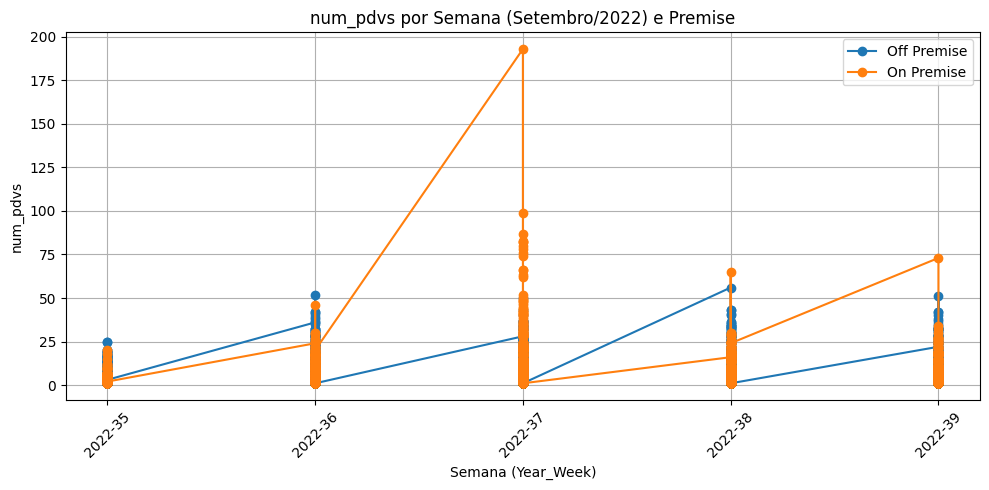

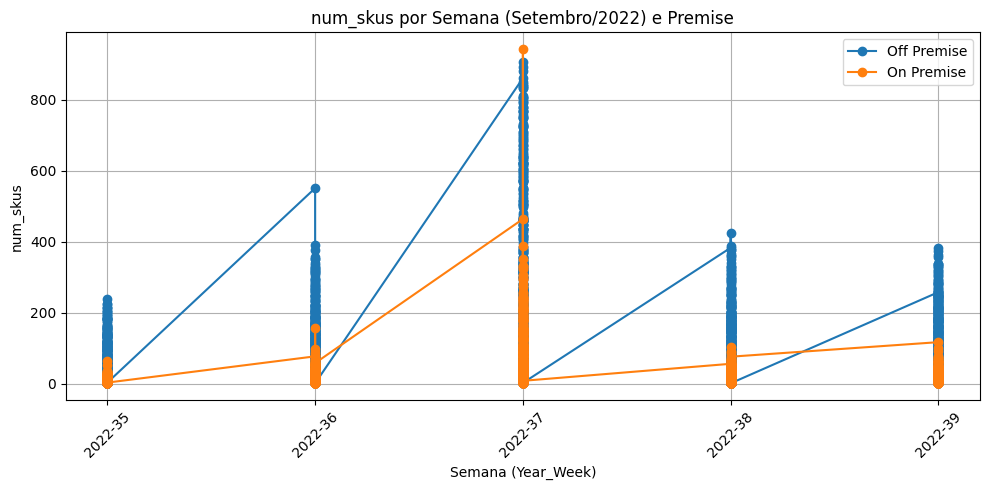

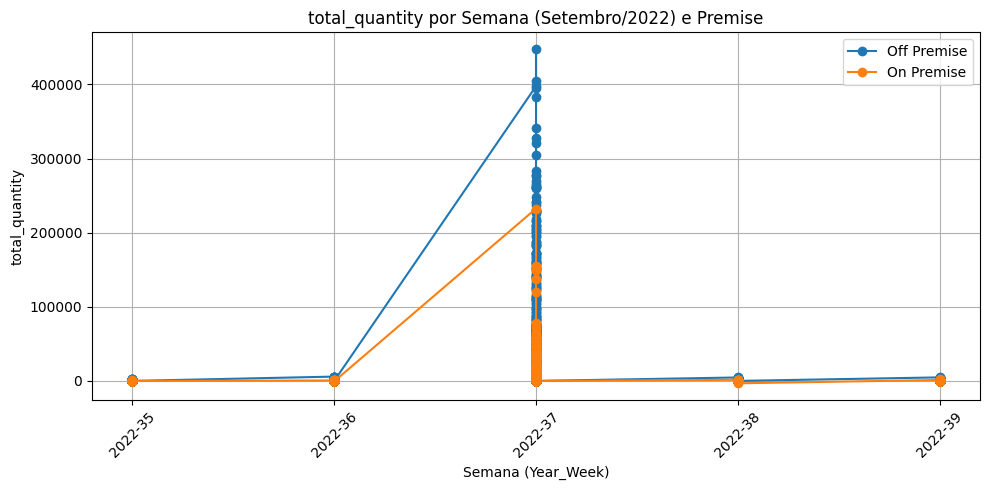

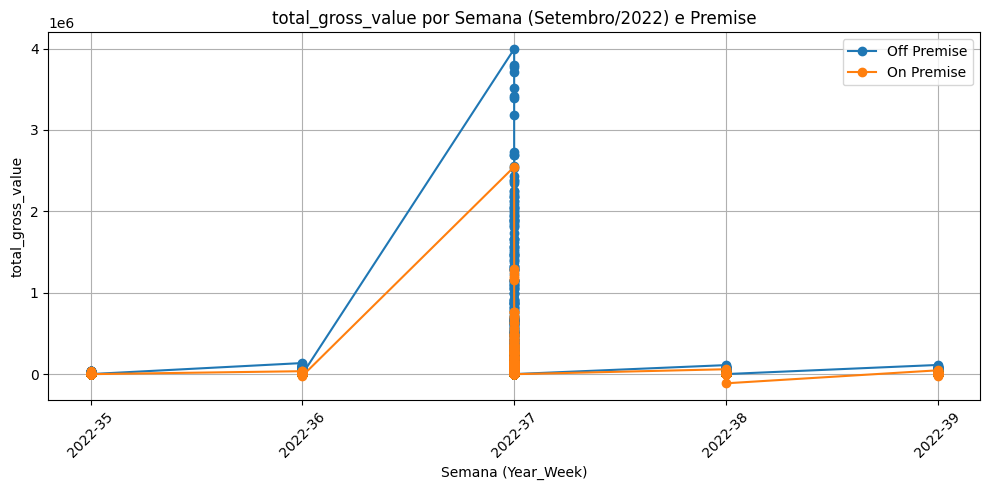

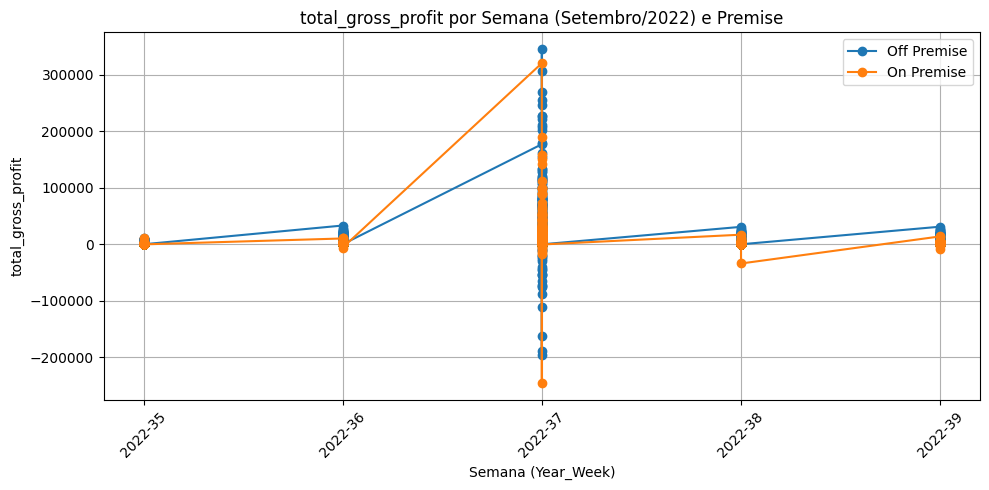

In [27]:
# Filtrar somente semanas de setembro de 2022
semanas_setembro = weekly_agg[weekly_agg['year_week'].between('2022-35', '2022-39')]

# Lista de métricas a serem plotadas
metrics = ['num_pdvs', 'num_skus', 'total_quantity', 'total_gross_value', 'total_gross_profit']

# Plotar cada métrica separada por 'premise'
for metric in metrics:
    plt.figure(figsize=(10, 5))
    for premise_type in semanas_setembro['premise'].unique():
        df_plot = semanas_setembro[semanas_setembro['premise'] == premise_type]
        plt.plot(df_plot['year_week'], df_plot[metric], marker='o', label=premise_type)

    plt.title(f'{metric} por Semana (Setembro/2022) e Premise')
    plt.xlabel('Semana (Year_Week)')
    plt.ylabel(metric)
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Durante a análise temporal das métricas principais: quantidade de PDVs, número de SKUs, total de produtos vendidos, receita bruta (gross_value) e lucro bruto (gross_profit), observamos uma anomalia severa na semana 37 do ano de 2022 (correspondente a meados de setembro).

Essa semana apresentou valores significativamente acima do padrão histórico, tanto para o canal On Premise quanto Off Premise. O comportamento se repete em todas as métricas analisadas, conforme evidenciado nos gráficos semanais.

##### Decisão:

Foi decidido remover apenas a semana 37/2022 do dataset por entender que:
	•	Trata-se de um ponto completamente fora da curva, que não reflete o comportamento regular dos dados.
	•	A manutenção dessa semana causaria enviesamento nas análises descritivas e nos modelos preditivos.
	•	O valor retorna ao patamar anterior já na semana seguinte, o que reforça o caráter isolado do evento.

Possíveis causas:
	•	Erro de carga ou duplicação de dados no sistema de origem.
	•	Onboarding massivo pontual de PDVs ou campanhas promocionais incomuns.
	•	Anomalia operacional não documentada.

In [30]:
df['transaction_date'] = pd.to_datetime(df['transaction_date'])

# Criar coluna de ano-semana para análise
df['year_week'] = df['transaction_date'].dt.strftime('%Y-%U')

# Filtrar removendo a semana 37 de 2022
df = df[df['year_week'] != '2022-37']

In [31]:
df.head(10)

,pdv,produto,distributor_id,transaction_date,reference_date,quantity,gross_value,net_value,gross_profit,discount,taxes,categoria,label,marca,fabricante,premise,categoria_pdv,month,year_week
0,7384367747233276219,328903483604537190,9,2022-07-13,2022-07-01,1.0,38.125000,37.890625,10.042625,3.95,0.234375,Package,Core,Bud Light Chelada Fuego,AB Anheuser Busch Inc,Off Premise,Package/Liquor,2022-07,2022-28
1,3536908514005606262,5418855670645487653,5,2022-03-21,2022-03-01,6.0,107.250000,106.440002,24.732002,17.10,0.810000,Package,Core,Michelob Ultra,AB Anheuser Busch Inc,Off Premise,Package/Liquor,2022-03,2022-12
2,3138231730993449825,1087005562675741887,6,2022-09-06,2022-09-01,3.0,56.625000,56.220001,14.124002,5.25,0.405000,Package,Core,Bud Light Lime,AB Anheuser Busch Inc,Off Premise,Package/Liquor,2022-09,2022-36
4,7762413312337359369,6614994347738381720,4,2022-02-18,2022-02-01,1.0,26.230000,23.950241,6.550241,0.00,2.279758,Package,Core,New Belgium Voodoo Ranger Imperial IPA,NB New Belgium,Off Premise,Convenience,2022-02,2022-07
6,1027356552181929439,576514643033029430,4,2022-10-04,2022-10-01,7.0,153.754997,133.807114,40.518112,23.45,19.947886,Package,Core,Busch,AB Anheuser Busch Inc,Off Premise,Super Center,2022-10,2022-40
8,7752780566579715772,5418855670645487653,4,2022-06-21,2022-06-01,12.0,223.703999,203.186169,54.818170,15.60,20.517828,Package,Core,Michelob Ultra,AB Anheuser Busch Inc,Off Premise,Package/Liquor,2022-06,2022-25
9,5339226423887032797,2126695985526201979,5,2022-10-06,2022-10-01,1.0,42.799999,42.619999,12.772999,6.18,0.180000,Package,Core,10 Barrel Crush Cucumber Sour,Tilray Brands,Off Premise,Package/Liquor,2022-10,2022-40
11,4441969626842003596,7890016101383296727,4,2022-06-14,2022-06-01,2.0,18.500000,18.500000,4.518330,6.10,0.000000,Non-Alcohol,Core,Sparkling Ice Peach Nectarine,Talking Rain,Off Premise,Grocery,2022-06,2022-24
12,6825966060938407713,9149212002603716850,4,2022-05-25,2022-05-01,3.0,80.250000,73.410728,20.727728,0.00,6.839274,Package,Core,Bud Light Lime,AB Anheuser Busch Inc,Off Premise,Grocery,2022-05,2022-21
13,5538851823321709722,6189453893821323891,4,2022-04-26,2022-04-01,1.0,19.743999,16.704323,4.090323,1.85,3.039677,Package,Core,Busch Light,AB Anheuser Busch Inc,Off Premise,Convenience,2022-04,2022-17


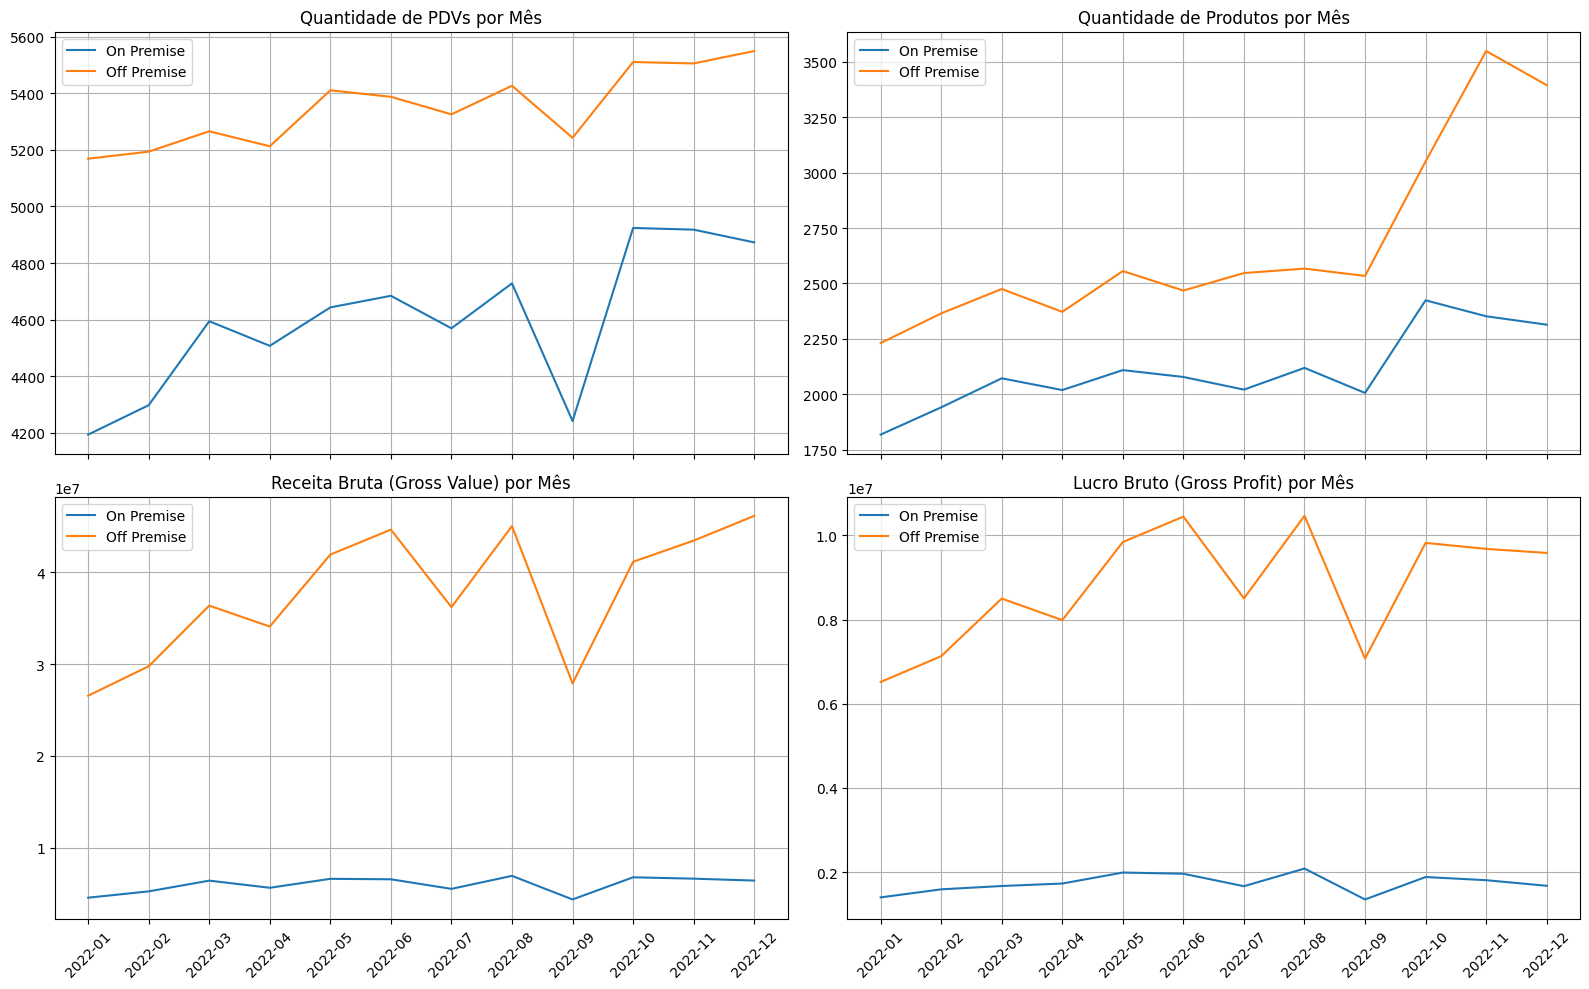

In [33]:
# plotando novamente o grafico

df['reference_date'] = pd.to_datetime(df['reference_date'])

df['month'] = df['reference_date'].dt.to_period('M').astype(str)

# Agrupar dados por mês e premise
monthly_summary = df.groupby(['premise', 'month']).agg(
    num_pdvs=('pdv', 'nunique'),
    num_products=('produto', 'nunique'),
    gross_value=('gross_value', 'sum'),
    gross_profit=('gross_profit', 'sum')
).reset_index()

# Separar On Premise e Off Premise
df_on = monthly_summary[monthly_summary['premise'] == 'On Premise']
df_off = monthly_summary[monthly_summary['premise'] == 'Off Premise']

# Plotar
fig, axs = plt.subplots(2, 2, figsize=(16, 10), sharex=True)

# Gráfico 1 - Quantidade de PDVs
axs[0, 0].plot(df_on['month'], df_on['num_pdvs'], label='On Premise')
axs[0, 0].plot(df_off['month'], df_off['num_pdvs'], label='Off Premise')
axs[0, 0].set_title('Quantidade de PDVs por Mês')
axs[0, 0].legend()

# Gráfico 2 - Quantidade de Produtos
axs[0, 1].plot(df_on['month'], df_on['num_products'], label='On Premise')
axs[0, 1].plot(df_off['month'], df_off['num_products'], label='Off Premise')
axs[0, 1].set_title('Quantidade de Produtos por Mês')
axs[0, 1].legend()

# Gráfico 3 - Receita Bruta (Gross Value)
axs[1, 0].plot(df_on['month'], df_on['gross_value'], label='On Premise')
axs[1, 0].plot(df_off['month'], df_off['gross_value'], label='Off Premise')
axs[1, 0].set_title('Receita Bruta (Gross Value) por Mês')
axs[1, 0].legend()

# Gráfico 4 - Lucro Bruto (Gross Profit)
axs[1, 1].plot(df_on['month'], df_on['gross_profit'], label='On Premise')
axs[1, 1].plot(df_off['month'], df_off['gross_profit'], label='Off Premise')
axs[1, 1].set_title('Lucro Bruto (Gross Profit) por Mês')
axs[1, 1].legend()

# Ajustes finais
for ax in axs.flat:
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True)

plt.tight_layout()
plt.show()

Durante a análise semanal do mês de setembro de 2022, foi identificado anomalias significativas nas semanas 37 e 38:
	•	A semana 37 apresentou valores extremamente altos, destoando do comportamento padrão ao longo do ano.
	•	A semana 38, por sua vez, apresentou valores artificialmente baixos, sugerindo uma possível compensação ou ausência parcial de dados.

Para preservar a integridade estatística das análises, decidiu-se por excluir ambas as semanas. Essa decisão visa garantir que as análises e modelos construídos não sejam influenciados por dados inconsistentes ou distorcidos.

In [34]:
# Remover a semana 38 de 2022
df = df[df['year_week'] != '2022-38']

#### Objetivo

Focar nas marcas que concentram 80% da quantidade de transações, e analisá-las em profundidade com:

- Volume de vendas

- Receita (gross_value)

- Lucro bruto (gross_profit)

- Custo operacional estimado =  gross_value - gross_profit

- Receita líquida (net_value)

- Descontos (discount)

- Impostos (taxes)

- Lucro líquido estimado = net_value - discount - taxes

In [36]:
# Verifique se a coluna 'year_week' está em formato datetime/sequencial. Se não, crie ela novamente:
df['year_week'] = df['transaction_date'].dt.strftime('%Y-%U')

# Pega as últimas 12 semanas disponíveis nos dados
ultimas_12_semanas = sorted(df['year_week'].unique())[-12:]

# Filtra o dataframe
df_ultimas_semanas = df[df['year_week'].isin(ultimas_12_semanas)]

# Agrupa por marca e premise e calcula os indicadores
agg = (
    df_ultimas_semanas.groupby(['marca', 'premise'])
    .agg(
        total_quantity=('quantity', 'sum'),
        total_gross_profit=('gross_profit', 'sum'),
        total_gross_value=('gross_value', 'sum'),
        total_net_value=('net_value', 'sum'),
        total_discount=('discount', 'sum'),
        total_taxes=('taxes', 'sum')
    )
    .reset_index()
)

# Cálculos derivados
agg['estimated_cost_ops'] = agg['total_gross_value'] - agg['total_gross_profit']
agg['estimated_net_profit'] = agg['total_net_value'] - agg['total_discount'] - agg['total_taxes']

# Mantém só as colunas que você pediu
final_df = agg[[
    'marca', 'premise',
    'total_quantity',
    'total_gross_profit',
    'estimated_cost_ops',
    'estimated_net_profit'
]]

# Ordena para destacar as marcas mais relevantes
final_df = final_df.sort_values(by='total_quantity', ascending=False)

# Exibe as 20 maiores para visualizar
final_df.head(20)

,marca,premise,total_quantity,total_gross_profit,estimated_cost_ops,estimated_net_profit
739,Bud Light,Off Premise,1.069093e+06,5.649167e+06,1.835263e+07,1.865936e+07
1775,Fireball Cinnamon Whiskey,Off Premise,5.850665e+05,5.788512e+05,5.792470e+06,5.062931e+06
2962,Michelob Ultra,Off Premise,5.473659e+05,3.782866e+06,1.041719e+07,1.170816e+07
805,Budweiser,Off Premise,4.756550e+05,2.572309e+06,8.277781e+06,8.604570e+06
4093,Skol Premium Vodka,Off Premise,2.656070e+05,1.375782e+05,9.184006e+05,7.877662e+05
3181,Natural Light,Off Premise,1.779868e+05,8.575145e+05,2.905747e+06,2.550042e+06
827,Busch Light,Off Premise,1.553573e+05,7.239816e+05,2.462668e+06,2.296556e+06
737,Bud Ice,Off Premise,1.232869e+05,5.406528e+05,2.165459e+06,1.659737e+06
824,Busch,Off Premise,1.121157e+05,5.094587e+05,1.825376e+06,1.649059e+06
740,Bud Light,On Premise,1.107873e+05,1.589399e+06,3.174311e+06,4.162755e+06


In [49]:
import pandas as pd

# Filtrar as últimas 12 semanas disponíveis
ultimas_semanas = df['year_week'].drop_duplicates().sort_values().tail(12).tolist()
df_filtrado = df[df['year_week'].isin(ultimas_semanas)].copy()

# Calcular colunas derivadas
df_filtrado['estimated_cost_ops'] = df_filtrado['gross_value'] - df_filtrado['gross_profit']
df_filtrado['estimated_net_profit'] = df_filtrado['net_value'] - df_filtrado['discount'] - df_filtrado['taxes']

# Agrupar por PDV e Premise
df_resultado = df_filtrado.groupby(['pdv', 'premise']).agg(
    quantity=('quantity', 'sum'),
    gross_value=('gross_value', 'sum'),
    estimated_cost_ops=('estimated_cost_ops', 'sum'),
    gross_profit=('gross_profit', 'sum'),
    net_value=('net_value', 'sum'),
    discount=('discount', 'sum'),
    taxes=('taxes', 'sum'),
    estimated_net_profit=('estimated_net_profit', 'sum')
).reset_index()

# Separar entre ON e OFF Premise
df_on = df_resultado[df_resultado['premise'] == 'On Premise']
df_off = df_resultado[df_resultado['premise'] == 'Off Premise']

# Visualizar os Top 10 PDVs por volume de vendas
print("ON-PREMISE (TOP 10 por quantidade)")
display(df_on.sort_values(by='quantity', ascending=False).head(10))

print("\nOFF-PREMISE (TOP 10 por quantidade)")
display(df_off.sort_values(by='quantity', ascending=False).head(10))

ON-PREMISE (TOP 10 por quantidade)


,pdv,premise,quantity,gross_value,estimated_cost_ops,gross_profit,net_value,discount,taxes,estimated_net_profit
517,1365839146278641704,On Premise,17616.000000,169225.418873,148088.993087,21136.425786,162195.672676,42194.919402,7029.746493,112971.006782
6338,5544154622735077354,On Premise,10485.000000,86690.939638,73375.249760,13315.689878,80248.751444,25170.560189,6442.188728,48636.002527
5680,5077327874228029971,On Premise,6346.500000,240921.805979,188175.618232,52746.187747,235177.587502,56959.479338,5744.218429,172473.889735
9075,7535235951675607466,On Premise,2604.000000,32255.730021,24075.150989,8180.579032,30897.744003,8705.829998,1357.986021,20833.927984
304,1217943773325345571,On Premise,2539.000000,109835.833902,77436.593602,32399.240301,108213.601992,10634.340006,1622.231643,95957.030343
9350,7719858014634884431,On Premise,2308.000000,19671.538227,16718.680266,2952.857961,18077.921309,2346.749977,1593.616621,14137.554711
9869,8079536675230586368,On Premise,1886.958333,77808.061999,55699.173174,22108.888825,75574.398085,7817.367878,2233.663730,65523.366478
471,1330016643356098638,On Premise,1854.000000,33531.851147,18734.847160,14797.003987,32279.257812,5025.462574,1252.593496,26001.201742
11214,9038563639418584028,On Premise,1848.000000,54714.960135,42266.203287,12448.756848,53903.953659,3100.219932,811.006999,49992.726727
271,1194636340739726889,On Premise,1695.000000,51952.415560,37501.407821,14451.007739,51511.529945,955.500008,440.886104,50115.143834



OFF-PREMISE (TOP 10 por quantidade)


,pdv,premise,quantity,gross_value,estimated_cost_ops,gross_profit,net_value,discount,taxes,estimated_net_profit
7596,6491855528940268514,Off Premise,18428.716666,358499.489818,305818.882163,52680.607655,347145.408100,47516.054740,11354.080751,288275.272609
7390,6337402841339348330,Off Premise,16598.000000,335660.859082,273507.235085,62153.623997,326988.728254,42203.932811,8672.132291,276112.663152
8592,7195906766187577140,Off Premise,16585.250000,330688.537106,266442.652826,64245.884279,321797.803860,49111.940104,8890.734582,263795.129174
4694,4374038751643985193,Off Premise,16495.000000,308290.945848,256306.356998,51984.588850,299608.912335,55540.839136,8682.033029,235386.040171
10748,8723723113467008071,Off Premise,16422.500000,281039.897152,236012.749840,45027.147312,270244.895362,37887.735183,10795.001438,221562.158741
2860,3025867614395044464,Off Premise,15891.416667,285393.797762,233833.549497,51560.248266,277211.631642,42165.941790,8182.166048,226863.523804
10140,8294871217390043140,Off Premise,15063.233333,283952.631449,240080.282393,43872.349056,275105.134592,48331.762589,8847.496711,217925.875292
8406,7059328007645110932,Off Premise,14497.933333,113335.538522,92270.184331,21065.354191,108321.725908,12998.082730,5013.812397,90309.830781
3353,338592148842312906,Off Premise,13355.000000,261250.871008,201730.331701,59520.539307,255707.902011,38193.514767,5542.969813,211971.417431
4606,4304226119364518876,Off Premise,13103.050000,248107.410655,203253.939779,44853.470876,241982.307110,41647.116666,6125.103740,194210.086704


### INSIGHTS - PORTFÓLIO BIG DATA

A análise dos 10 principais PDVs por canal (On e Off Premise), com base nas últimas 12 semanas, nos permite identificar quais pontos de venda combinam alto volume, lucro bruto e lucro líquido estimado. A partir disso, propomos a aplicação das soluções do portfólio da empresa de forma orientada por dados:

⸻

##### 1. One-Click Order → Recomendação de sortimento ideal

PDVs com alto volume de vendas nem sempre apresentam o maior lucro líquido. Isso indica possíveis gaps de sortimento, ou mix mal otimizado.

Como conecta:
Aplicar o One-Click Order nesses PDVs permite recomendar os SKUs mais rentáveis e adequados ao perfil de consumo local, maximizando margens e giro. Por exemplo:
	•	PDVs Off-Premise com grande volume, mas custo operacional elevado, se beneficiariam de um sortimento mais eficiente.
	•	Algoritmos podem cruzar o perfil de venda com a performance dos SKUs mais lucrativos.

⸻

##### 2. PriceO → Otimização de preços por praça e canal

Diferenças relevantes de lucro líquido entre PDVs com volumes similares, mesmo dentro do mesmo canal. Isso pode estar relacionado a estratégias de desconto ou precificação desalinhada.

Como conecta:
O PriceO pode atuar ajustando preços de forma dinâmica e local. Exemplo:
	•	PDVs On-Premise com margens comprimidas podem ter preços ou descontos mal calibrados.
	•	PriceO identifica o ponto ótimo de preço por canal, mix e perfil da região.

⸻

##### 3. TargAtom → Metas realistas e individualizadas

Alguns PDVs têm lucro líquido alto mesmo com volume médio — isso sinaliza alto potencial de rentabilidade subaproveitado.

Como conecta:
O TargAtom pode definir metas personalizadas baseadas não só no histórico, mas no potencial real do PDV — considerando rentabilidade, não apenas volume. Isso melhora:
	•	Planejamento de vendas
	•	Alocação de recursos da equipe
	•	Priorização de visitas

⸻

##### 4. Media Hero → Alocação eficiente de verba de marketing

PDVs com alta performance podem estar localizados em regiões com alto retorno potencial para investimento em mídia local ou ativações.

Como conecta:
Com base na performance financeira por PDV, o Media Hero pode:
	•	Mapear onde ativar campanhas promocionais ou de marca
	•	Priorizar canais e regiões com maior retorno estimado
	•	Ajustar estratégia de mídia local com base em dados reais

⸻

##### Conclusão

A análise por PDV vai muito além do Gross Profit: ao considerar o lucro líquido estimado, conseguimos identificar quais pontos são mais estratégicos para alavancar resultados. Com isso, cada solução do portfólio pode ser direcionada de forma assertiva, maximizando impacto comercial e operacional.

#### Correlação entre variáveis contínuas

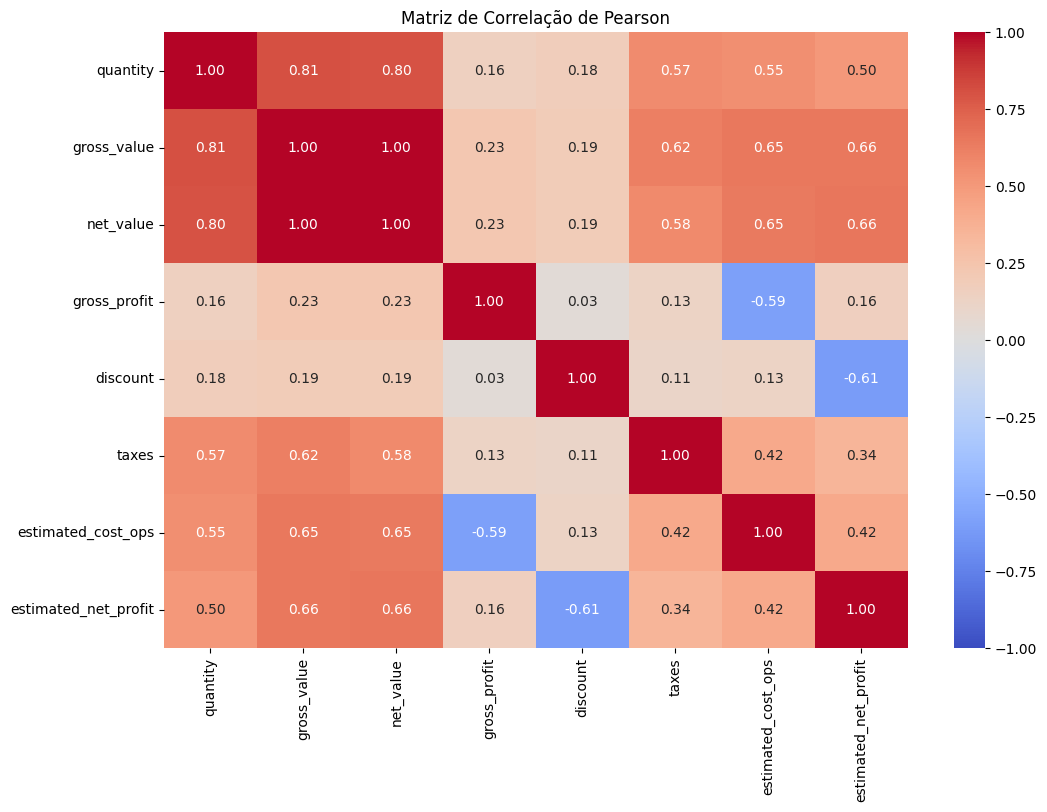


Pares com alta correlação (> 0.85):


gross_value  net_value      0.998734
net_value    gross_value    0.998734
dtype: float64

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Filtrar colunas numéricas
numericas = df.select_dtypes(include='number')

# Calcular matriz de correlação de Pearson
corr = numericas.corr(method='pearson')

# Visualizar com heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title('Matriz de Correlação de Pearson')
plt.show()

# Listar pares de variáveis com correlação alta (> 0.85 e < 1.0)
print("\nPares com alta correlação (> 0.85):")
high_corr = (
    corr.where((abs(corr) > 0.85) & (abs(corr) < 1.0))
        .stack()
        .sort_values(ascending=False)
)

display(high_corr)

##### Decisão 

Após a análise exploratória e cálculo da matriz de correlação de Pearson entre variáveis numéricas, foi observado alta colinearidade entre diversas features derivadas, especialmente aquelas construídas a partir das métricas de receita e lucro.

Para evitar overfitting, reduzir custo computacional e melhorar a interpretabilidade do modelo, optou-se por manter apenas variáveis com maior capacidade explicativa e que não são combinações diretas de outras.

Critérios adotados:
	•	Manter variáveis brutas e eliminar derivadas altamente correlacionadas.
	•	Priorizar variáveis de entrada com maior poder de ação (ex: preço, canal, tipo de PDV).
	•	Manter variáveis independentes para cálculo de métricas como elasticidade, margem, promoções etc.

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6015564 entries, 0 to 6560697
Data columns (total 16 columns):
 #   Column          Dtype  
---  ------          -----  
 0   pdv             object 
 1   produto         object 
 2   distributor_id  object 
 3   quantidade      float64
 4   gross_value     float64
 5   net_value       float64
 6   gross_profit    float64
 7   discount        float64
 8   taxes           float64
 9   categoria       object 
 10  label           object 
 11  marca           object 
 12  fabricante      object 
 13  premise         object 
 14  categoria_pdv   object 
 15  semana          object 
dtypes: float64(6), object(10)
memory usage: 780.2+ MB


In [56]:
df.head()

,pdv,produto,distributor_id,quantidade,gross_value,net_value,gross_profit,discount,taxes,categoria,label,marca,fabricante,premise,categoria_pdv,semana
0,7384367747233276219,328903483604537190,9,1.0,38.125000,37.890625,10.042625,3.95,0.234375,Package,Core,Bud Light Chelada Fuego,AB Anheuser Busch Inc,Off Premise,Package/Liquor,2022-28
1,3536908514005606262,5418855670645487653,5,6.0,107.250000,106.440002,24.732002,17.10,0.810000,Package,Core,Michelob Ultra,AB Anheuser Busch Inc,Off Premise,Package/Liquor,2022-12
2,3138231730993449825,1087005562675741887,6,3.0,56.625000,56.220001,14.124002,5.25,0.405000,Package,Core,Bud Light Lime,AB Anheuser Busch Inc,Off Premise,Package/Liquor,2022-36
4,7762413312337359369,6614994347738381720,4,1.0,26.230000,23.950241,6.550241,0.00,2.279758,Package,Core,New Belgium Voodoo Ranger Imperial IPA,NB New Belgium,Off Premise,Convenience,2022-07
6,1027356552181929439,576514643033029430,4,7.0,153.754997,133.807114,40.518112,23.45,19.947886,Package,Core,Busch,AB Anheuser Busch Inc,Off Premise,Super Center,2022-40


In [57]:
# Garante que está em string
df['semana'] = df['semana'].astype(str)

# Extrai ano e número da semana
df['ano'] = df['semana'].str.extract(r'(\d{4})').astype(int)
df['num_semana'] = df['semana'].str.extract(r'-(\d{2})').astype(int)

In [58]:
df.head()

,pdv,produto,distributor_id,quantidade,gross_value,net_value,gross_profit,discount,taxes,categoria,label,marca,fabricante,premise,categoria_pdv,semana,ano,num_semana
0,7384367747233276219,328903483604537190,9,1.0,38.125000,37.890625,10.042625,3.95,0.234375,Package,Core,Bud Light Chelada Fuego,AB Anheuser Busch Inc,Off Premise,Package/Liquor,2022-28,2022,28
1,3536908514005606262,5418855670645487653,5,6.0,107.250000,106.440002,24.732002,17.10,0.810000,Package,Core,Michelob Ultra,AB Anheuser Busch Inc,Off Premise,Package/Liquor,2022-12,2022,12
2,3138231730993449825,1087005562675741887,6,3.0,56.625000,56.220001,14.124002,5.25,0.405000,Package,Core,Bud Light Lime,AB Anheuser Busch Inc,Off Premise,Package/Liquor,2022-36,2022,36
4,7762413312337359369,6614994347738381720,4,1.0,26.230000,23.950241,6.550241,0.00,2.279758,Package,Core,New Belgium Voodoo Ranger Imperial IPA,NB New Belgium,Off Premise,Convenience,2022-07,2022,7
6,1027356552181929439,576514643033029430,4,7.0,153.754997,133.807114,40.518112,23.45,19.947886,Package,Core,Busch,AB Anheuser Busch Inc,Off Premise,Super Center,2022-40,2022,40


In [59]:
df_model = df[df['ano'] == 2022].copy()

In [61]:
df_model.drop(columns=['semana'], inplace=True)

In [62]:
df_model.rename(columns={'num_semana': 'semana'}, inplace=True)

In [63]:
df_model.head()

,pdv,produto,distributor_id,quantidade,gross_value,net_value,gross_profit,discount,taxes,categoria,label,marca,fabricante,premise,categoria_pdv,semana
0,7384367747233276219,328903483604537190,9,1.0,38.125000,37.890625,10.042625,3.95,0.234375,Package,Core,Bud Light Chelada Fuego,AB Anheuser Busch Inc,Off Premise,Package/Liquor,28
1,3536908514005606262,5418855670645487653,5,6.0,107.250000,106.440002,24.732002,17.10,0.810000,Package,Core,Michelob Ultra,AB Anheuser Busch Inc,Off Premise,Package/Liquor,12
2,3138231730993449825,1087005562675741887,6,3.0,56.625000,56.220001,14.124002,5.25,0.405000,Package,Core,Bud Light Lime,AB Anheuser Busch Inc,Off Premise,Package/Liquor,36
4,7762413312337359369,6614994347738381720,4,1.0,26.230000,23.950241,6.550241,0.00,2.279758,Package,Core,New Belgium Voodoo Ranger Imperial IPA,NB New Belgium,Off Premise,Convenience,7
6,1027356552181929439,576514643033029430,4,7.0,153.754997,133.807114,40.518112,23.45,19.947886,Package,Core,Busch,AB Anheuser Busch Inc,Off Premise,Super Center,40


In [66]:
# Salvar dataset processado para modelagem
df_model.to_parquet("../data/processed/base_modelagem.parquet", index=False)

### Modelagem

In [ ]:
# padroniza colunas para lower
    df_trans.columns = df_trans.columns.str.lower()
    df_pdv.columns   = df_pdv.columns.str.lower()
    df_prod.columns  = df_prod.columns.str.lower()